In [2]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [3]:

class State(TypedDict):
    messages: Annotated[list,add_messages]


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [6]:
from langchain_groq import ChatGroq

In [7]:
llm = ChatGroq( model_name="llama3-8b-8192")


In [8]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [10]:
graph_builder=StateGraph(State)
graph_builder.add_node("llmchatbot",chatbot)
graph_builder.add_edge(START,"llmchatbot")

graph_builder.add_edge("llmchatbot",END)
graph=graph_builder.compile()



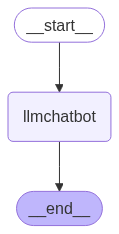

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
response=graph.invoke({"messages":"Hi"})

In [15]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [17]:
for event in graph.stream({"messages": "hello how are you?"}):
    for value in event.values():
        print(value)

{'messages': [AIMessage(content="Hello! I'm just an AI, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have! How about you, how's your day going?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 15, 'total_tokens': 65, 'completion_time': 0.069811533, 'prompt_time': 0.003790814, 'queue_time': 0.266654159, 'total_time': 0.073602347}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ae25bd88-578f-4d9c-904d-72141ef2c09f-0', usage_metadata={'input_tokens': 15, 'output_tokens': 50, 'total_tokens': 65})]}


In [55]:
from langchain_tavily import TavilySearch
tavily=TavilySearch()

In [56]:
def multiply(a:int,b:int)->int:
    """multiply a and b
    Args:
        a(int): 1st integer
        
        b(int): 2nd integer
    return:
        
        int: output_int    """
    return a*b
    
    

In [57]:
tools=[tavily,multiply]

In [58]:
llmwt=llm.bind_tools(tools)

In [59]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [60]:
def tool_calling_llm(state:State):
    return {"messages":[llmwt.invoke(state["messages"])]}

In [61]:
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))





In [62]:
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)

In [63]:
builder.add_edge("tools","tool_calling_llm")

In [64]:
graph_builder=builder.compile()

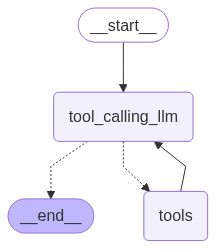

In [65]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [48]:
response=graph_builder.invoke({"messages":"Hi what is latest ai news"})

In [49]:
response["messages"][-1].content

'{"query": "latest ai news", "follow_up_questions": null, "answer": null, "images": ["https://autogpt.net/wp-content/uploads/2023/07/Pogla_Explore_the_latest_AI_news_from_groundbreaking_drug_trial_07ab875d-1e11-42d5-89ef-39ff3d5ab451.jpg", "https://assets.weforum.org/editor/Ktdhn0KNfhbpY_AE77yZFRYJ9zUl9hnFcncbE53QzUQ.PNG", "https://www.solulab.com/wp-content/uploads/2024/01/Top-Artificial-Intelligence-Trends.jpg", "https://xtracta.com/wp-content/uploads/2022/02/artificial-intelligence-trends.jpg", "https://fastestvpn.com/blog/wp-content/uploads/2023/02/10-Latest-AI-Inventions-f.png"], "results": [{"url": "https://www.nytimes.com/spotlight/artificial-intelligence", "title": "Artificial Intelligence - The New York Times", "content": "Outside a Senate Judiciary Committee hearing on online child sexual exploitation in 2024. Images of child sexual abuse created by the latest A.I. technology have become smoother and more detailed. \\n\\nThe A.I. Frenzy Is Escalating. Again.\\n\\nCompanies li

In [50]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi what is latest ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (x6dfcxg7f)
 Call ID: x6dfcxg7f
  Args:
    exclude_domains: []
    include_domains: []
    include_favicon: False
    include_images: True
    query: latest ai news
    search_depth: advanced
    start_date: None
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest ai news", "follow_up_questions": null, "answer": null, "images": ["https://autogpt.net/wp-content/uploads/2023/07/Pogla_Explore_the_latest_AI_news_from_groundbreaking_drug_trial_07ab875d-1e11-42d5-89ef-39ff3d5ab451.jpg", "https://assets.weforum.org/editor/Ktdhn0KNfhbpY_AE77yZFRYJ9zUl9hnFcncbE53QzUQ.PNG", "https://www.solulab.com/wp-content/uploads/2024/01/Top-Artificial-Intelligence-Trends.jpg", "https://xt

In [51]:
response=graph_builder.invoke({"messages":"Hi what is 2 muntiply by 5"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi what is 2 muntiply by 5
================================== Ai Message ==================================
Tool Calls:
  multiply (ybf29m6sg)
 Call ID: ybf29m6sg
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10


In [66]:
response=graph_builder.invoke({"messages":"Hi what is 2 muntiply by 5 and tel me about mathematics"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi what is 2 muntiply by 5 and tel me about mathematics
================================== Ai Message ==================================
Tool Calls:
  multiply (8y7asy736)
 Call ID: 8y7asy736
  Args:
    a: 2
    b: 5
  tavily_search (ktrckm185)
 Call ID: ktrckm185
  Args:
    query: what is mathematics
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: multiply

10
================================= Tool Message =================================
Name: tavily_search

{"query": "what is mathematics", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.britannica.com/science/mathematics", "title": "Mathematics | Definition, History, & Importance - Britannica", "content": "mathematics, the science of structure, order, and relation that has evolved from elemental practices of counting, meas

In [67]:
response=graph_builder.invoke({"messages":"Hi what previous quesion i ask you"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi what previous quesion i ask you
================================== Ai Message ==================================

I'm a large language model, I don't have the ability to keep track of previous conversations or questions. Each time you interact with me, it's a new conversation. If you'd like to ask a question or discuss a topic, I'm here to help!


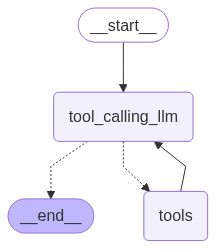

In [77]:
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

tavily=TavilySearch()
def multiply(a:int,b:int)->int:
    """multiply a and b
    Args:
        a(int): 1st integer
        
        b(int): 2nd integer
    return:
        
        int: output_int    """
    return a*b
tools=[tavily,multiply]
    
llmwt=llm.bind_tools(tools)
def tool_calling_llm(state:State):
    return {"messages":[llmwt.invoke(state["messages"])]}    
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph_builder=builder.compile(checkpointer=memory)

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [ ]:
config={"configurable":{"thread_id":"1"}}

In [79]:
response=graph_builder.invoke({"messages":"can you tell me about nabha city"},config=config)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

can you tell me about nabha city
================================== Ai Message ==================================
Tool Calls:
  tavily_search (pxt53k96b)
 Call ID: pxt53k96b
  Args:
    end_date: None
    query: Nabha city
    search_depth: advanced
    start_date: None
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Nabha city", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Nabha", "title": "Nabha - Wikipedia", "content": "Nabha is a city and municipal council in the Patiala district in the south-west of the Indian state of Punjab. It was the capital of the former Nabha State. Nabha is also a sub-division city which comes under Patiala district. [...] | Nabha | |\n| --- | --- |\n| City | |\n| Hira Mahal of Nabha | |\n| Nabha is located in

In [80]:
response=graph_builder.invoke({"messages":"Hi what previous quesion i ask you"},config=config)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

can you tell me about nabha city
================================== Ai Message ==================================
Tool Calls:
  tavily_search (pxt53k96b)
 Call ID: pxt53k96b
  Args:
    end_date: None
    query: Nabha city
    search_depth: advanced
    start_date: None
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Nabha city", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Nabha", "title": "Nabha - Wikipedia", "content": "Nabha is a city and municipal council in the Patiala district in the south-west of the Indian state of Punjab. It was the capital of the former Nabha State. Nabha is also a sub-division city which comes under Patiala district. [...] | Nabha | |\n| --- | --- |\n| City | |\n| Hira Mahal of Nabha | |\n| Nabha is located in

In [81]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

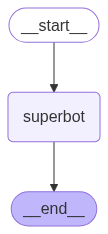

In [83]:
graph=StateGraph(State)
graph.add_node("superbot",superbot)\

graph.add_edge(START,"superbot")
graph.add_edge("superbot",END)

graph_builder=graph.compile(checkpointer=memory)

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [84]:
config={"configurable":{"thread_id":"1"}}
response=graph_builder.invoke({"messages":"hello my name is ms and i like cricket"},config=config)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

hello my name is ms and i like cricket
================================== Ai Message ==================================

Hello Ms! Nice to meet you! Cricket is a fantastic sport, isn't it? Who's your favorite team or player? Have you ever watched a live match or played a game yourself?


In [85]:
config = {"configurable": {"thread_id": "2"}}
response = None
for chunk in graph_builder.stream({"messages": "hello my name is ms and i like cricket"}, config, stream_mode="updates"):
    print(chunk)
#     response = chunk
# for m in response["messages"]:
#     m.pretty_print()

{'superbot': {'messages': [AIMessage(content="Hello Ms! Nice to meet you! It's great to know that you like cricket! Are you an avid fan of the game, or do you play it yourself?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 19, 'total_tokens': 54, 'completion_time': 0.049570695, 'prompt_time': 0.003902862, 'queue_time': 0.26198827199999997, 'total_time': 0.053473557}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--310c3358-fbe4-488d-bbba-8776039081a2-0', usage_metadata={'input_tokens': 19, 'output_tokens': 35, 'total_tokens': 54})]}}


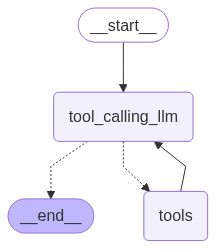

In [96]:

memory=MemorySaver()

tavily=TavilySearch()

from langgraph.types import Command,interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query:str)->str:
    """Request assistance from human"""
    human_response=interrupt({"query":query})
    return human_response["data"]

tools=[tavily,human_assistance]
    
llmwt=llm.bind_tools(tools)
def tool_calling_llm(state:State):
    return {"messages":[llmwt.invoke(state["messages"])]}    
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph_builder=builder.compile(checkpointer=memory)

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [97]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph_builder.stream({"messages": "can you give me human assistance  "}, config, stream_mode="values"):

    if "messages" in chunk:
        chunk["messages"][-1].pretty_print()

================================ Human Message =================================

can you give me human assistance  
================================== Ai Message ==================================
Tool Calls:
  human_assistance (p2d6d12s5)
 Call ID: p2d6d12s5
  Args:
    query: can you provide human assistance


In [98]:
human_response=("hi you can ask mithlesh about it")
human_command= Command(resume={"data":human_response})

for chunk in graph_builder.stream(human_command, config, stream_mode="values"):

    if "messages" in chunk:
        chunk["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (p2d6d12s5)
 Call ID: p2d6d12s5
  Args:
    query: can you provide human assistance
================================= Tool Message =================================
Name: human_assistance

hi you can ask mithlesh about it
================================== Ai Message ==================================

<tool-use>{"tool_calls":[]}</tool-use>
